# Imports & Environment Setup

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.4 MB/s eta 0:00:00


In [2]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms
from torch_geometric.loader import DataLoader as GraphLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Dataset, Data
import torch_geometric.utils as utils
from sklearn.metrics import f1_score, accuracy_score, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GRCNN Pipeline active on: {device}")

GRCNN Pipeline active on: cuda


# Graph Data Engineering

In [3]:
class PlantGraphDataset(Dataset):
    def __init__(self, subset):
        super().__init__()
        self.subset = subset

    def len(self):
        return len(self.subset)

    def get(self, idx):
        img_tensor, label = self.subset[idx]
        # Downsample for graph efficiency
        img = F.interpolate(img_tensor.unsqueeze(0), size=(32, 32)).squeeze(0)
        c, h, w = img.shape
        x = img.view(c, -1).t() # Features: [1024, 3]
        edge_index, _ = utils.grid(h, w) # 8-neighbor grid connectivity
        return Data(x=x, edge_index=edge_index, y=torch.tensor(label))

# Standard Preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and Split
full_dataset = datasets.ImageFolder('/kaggle/input/plantvillage-dataset/color', transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_sub, val_sub, test_sub = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

train_loader = GraphLoader(PlantGraphDataset(train_sub), batch_size=32, shuffle=True)
val_loader = GraphLoader(PlantGraphDataset(val_sub), batch_size=32, shuffle=False)
test_loader = GraphLoader(PlantGraphDataset(test_sub), batch_size=32, shuffle=False)

# The GRCNN Architecture

In [4]:
class PlantGRCNN(nn.Module):
    def __init__(self, num_classes=38):
        super(PlantGRCNN, self).__init__()
        # Graph Convolutional Layers
        self.conv1 = GCNConv(3, 64)
        self.conv2 = GCNConv(64, 128)
        
        # Recurrent Component (GRU/LSTM) 
        # We treat the pooled graph features as a sequence of 1
        self.rnn = nn.GRU(input_size=128, hidden_size=256, num_layers=1, batch_first=True)
        
        # Fully Connected Classifier
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # 1. Graph Feature Extraction
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        # 2. Global Pooling
        x = global_mean_pool(x, batch) # Shape: [batch_size, 128]
        
        # 3. Recurrent Processing
        # Unsqueeze to add sequence dimension: [batch_size, 1, 128]
        x = x.unsqueeze(1)
        out, _ = self.rnn(x)
        x = out[:, -1, :] # Take last hidden state
        
        return self.fc(x)

model = PlantGRCNN(num_classes=38).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training Loop & History Tracking

In [5]:
# 1. Initialize ALL keys correctly
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

print(f"{'Epoch':<8} | {'Val Acc':<10} | {'Val F1':<10} | {'Time':<8}")
print("-" * 45)

for epoch in range(25):
    start_time = time.time()
    
    # --- Training Phase ---
    model.train()
    t_loss, t_preds, t_labels = 0, [], []
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        t_loss += loss.item() * data.num_graphs
        t_preds.extend(out.argmax(dim=1).cpu().numpy())
        t_labels.extend(data.y.cpu().numpy())

    # --- Validation Phase ---
    model.eval()
    v_loss, v_preds, v_labels = 0, [], []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            v_loss += criterion(out, data.y).item() * data.num_graphs
            preds = out.argmax(dim=1)
            v_preds.extend(preds.cpu().numpy())
            v_labels.extend(data.y.cpu().numpy())

    # --- Metrics Calculation & Logging ---
    # Train Metrics
    train_acc = accuracy_score(t_labels, t_preds)
    train_f1 = f1_score(t_labels, t_preds, average='macro')
    
    # Val Metrics
    val_acc = accuracy_score(v_labels, v_preds)
    val_f1 = f1_score(v_labels, v_preds, average='macro')
    
    # STORE EVERYTHING in history (Fixes the ValueError)
    history['train_loss'].append(t_loss / len(train_sub))
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    
    history['val_loss'].append(v_loss / len(val_sub))
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"{epoch+1:<8} | {val_acc:<10.4f} | {val_f1:<10.4f} | {time.time()-start_time:<8.1f}s")

Epoch    | Val Acc    | Val F1     | Time    
---------------------------------------------
1        | 0.4757     | 0.2912     | 349.3   s
2        | 0.5895     | 0.4573     | 167.8   s
3        | 0.6545     | 0.5421     | 164.9   s
4        | 0.7199     | 0.6327     | 167.1   s
5        | 0.7387     | 0.6516     | 169.1   s
6        | 0.7527     | 0.6698     | 169.6   s
7        | 0.7751     | 0.7104     | 172.3   s
8        | 0.7825     | 0.7177     | 169.0   s
9        | 0.8009     | 0.7348     | 170.0   s
10       | 0.8125     | 0.7654     | 170.8   s
11       | 0.8110     | 0.7635     | 167.2   s
12       | 0.8252     | 0.7757     | 168.3   s
13       | 0.8256     | 0.7807     | 166.9   s
14       | 0.8359     | 0.7927     | 169.7   s
15       | 0.8250     | 0.7717     | 170.8   s
16       | 0.8512     | 0.8148     | 170.4   s
17       | 0.8571     | 0.8133     | 168.3   s
18       | 0.8543     | 0.8135     | 169.1   s
19       | 0.8634     | 0.8253     | 172.5   s
20       | 0.86

# GRCNN Performance Visualization

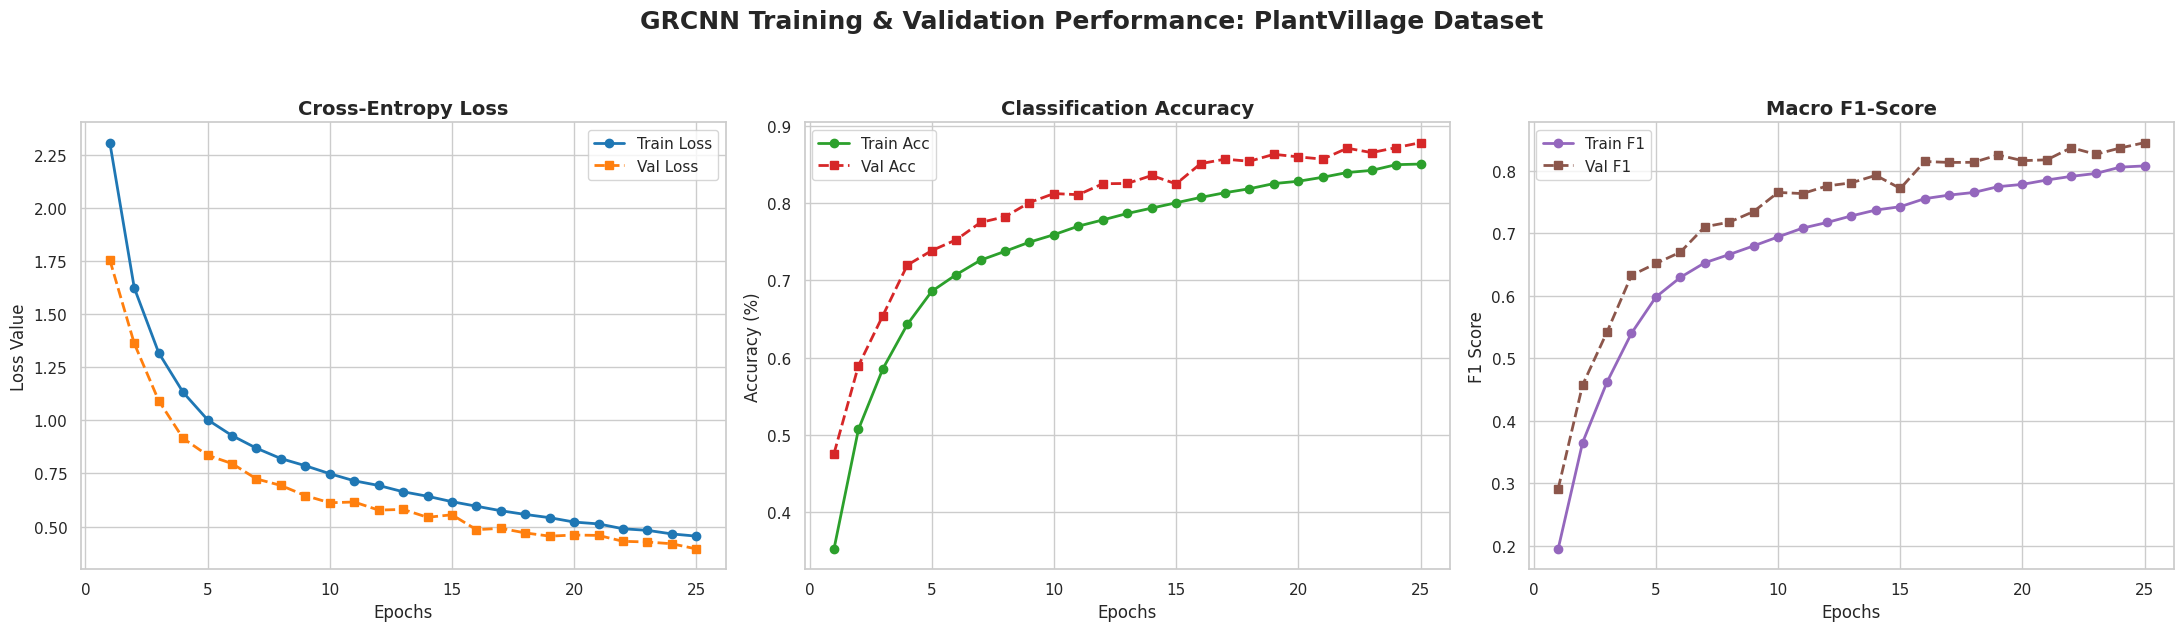

In [6]:
def plot_grcnn_history(history):
    # Set professional visual style
    sns.set_theme(style="whitegrid")
    epochs = range(1, len(history['val_acc']) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1. Loss Curve
    # Note: Ensure your history dict has 'train_loss' and 'val_loss'
    axes[0].plot(epochs, history.get('train_loss', []), 'o-', label='Train Loss', color='#1f77b4', linewidth=2)
    axes[0].plot(epochs, history.get('val_loss', []), 's--', label='Val Loss', color='#ff7f0e', linewidth=2)
    axes[0].set_title('Cross-Entropy Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss Value')
    axes[0].legend()

    # 2. Accuracy Curve
    axes[1].plot(epochs, history.get('train_acc', []), 'o-', label='Train Acc', color='#2ca02c', linewidth=2)
    axes[1].plot(epochs, history.get('val_acc', []), 's--', label='Val Acc', color='#d62728', linewidth=2)
    axes[1].set_title('Classification Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()

    # 3. Macro F1-Score Curve
    # This is crucial for your 38 classes to ensure balanced performance
    axes[2].plot(epochs, history.get('train_f1', []), 'o-', label='Train F1', color='#9467bd', linewidth=2)
    axes[2].plot(epochs, history.get('val_f1', []), 's--', label='Val F1', color='#8c564b', linewidth=2)
    axes[2].set_title('Macro F1-Score', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('F1 Score')
    axes[2].legend()

    plt.suptitle('GRCNN Training & Validation Performance: PlantVillage Dataset', fontsize=18, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# Run the visualizer
plot_grcnn_history(history)

# Final Evaluation & Testing

In [7]:
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        test_preds.extend(out.argmax(dim=1).cpu().numpy())
        test_labels.extend(data.y.cpu().numpy())

print("\n" + "="*30)
print("--- GRCNN FINAL TEST RESULTS ---")
print(f"Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
print(f"Macro F1: {f1_score(test_labels, test_preds, average='macro'):.4f}")
print("="*30)


--- GRCNN FINAL TEST RESULTS ---
Accuracy: 0.8777
Macro F1: 0.8371
